# Imports, setting up device and seeds

In [1]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
 
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# torch.cuda.set_device(1)
# device = torch.device("cuda")
# device = torch.device('mps')
device = torch.device('mps')

In [3]:
# torch.manual_seed(42)


import os
import random

def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_all_seeds(42)

# Constants

In [4]:
GOOGLE_COLAB_VERSION = False
VALIDATION_PERCENTAGE = 0.10
TRAIN_PATH = "./train"
TEST_PATH = "./test_all"

# Get data

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainFolder = torchvision.datasets.ImageFolder(root=TRAIN_PATH,
                                               transform=transform)

# trainloader = torch.utils.data.DataLoader(trainFolder, batch_size=batch_size,
#                                           shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(root=TEST_PATH, train=False,
#                                        download=False, transform=transform)

# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                          shuffle=False, num_workers=2)

In [6]:
# split into train and validation
train_size = int((1 - VALIDATION_PERCENTAGE) * len(trainFolder))
val_size = len(trainFolder) - train_size
train_subset, val_subset = torch.utils.data.random_split(trainFolder, [train_size, val_size])

In [7]:
len(train_subset.indices)

79209

In [8]:
len(val_subset.indices)

8802

In [9]:
# create dataloaders
train_dataloader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_subset, batch_size=256) # TODO: change to max, który się szybko liczy

In [10]:
test_batch = next(iter(train_dataloader))

In [11]:
test_batch[0].shape

torch.Size([32, 3, 64, 64])

In [12]:
classes = os.listdir(TRAIN_PATH)

In [13]:
# class Net(nn.Mobdule):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
#         self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.conv2 = nn.Conv2d(64, 128, 2)
#         self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.conv3 = nn.Conv2d(128, 256, 2)
#         self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.conv4 = nn.Conv2d(256, 512, 2)
#         self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

#         self.conv5 = nn.Conv2d(64, 128, 2)
#         self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.conv6 = nn.Conv2d(128, 128, 2)
#         self.pool6 = nn.MaxPool2d(kernel_size=2, stride=1)
#         self.conv7 = nn.Conv2d(128, 128, 2)
#         self.pool7 = nn.MaxPool2d(kernel_size=2, stride=1)
#         self.conv8 = nn.Conv2d(128, 128, 2)
#         self.pool8 = nn.MaxPool2d(kernel_size=2, stride=1)

#         self.fc1 = nn.Linear(4608, 1024)
#         self.fc2 = nn.Linear(1024, 50)

#     def forward(self, x):
#         x = self.pool1(F.relu(self.conv1(x)))
#         x = self.pool2(F.relu(self.conv2(x)))
#         x = self.pool3(F.relu(self.conv3(x)))
#         x = self.pool4(F.relu(self.conv4(x)))

#         # x = self.pool5(F.relu(self.conv5(x)))
#         # x = self.pool6(F.relu(self.conv6(x)))
#         # x = self.pool7(F.relu(self.conv7(x)))
#         # x = self.pool8(F.relu(self.conv8(x)))

#         # print(x.shape, x.shape[1] * x.shape[2] * x.shape[3])
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

In [14]:
# class LongNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         ## Warstwa konwolucyjna
#         self.n_convs =  4
#         n_channels = 32
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_channels, kernel_size=5, stride=1, padding=0)
#         self.conv2 = nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=5, stride=1, padding=0)
#         self.convs = [nn.Conv2d(in_channels=n_channels*2, out_channels=n_channels, kernel_size=5, stride=1, padding=2) for _ in range(self.n_convs)]
#         self.bns = [nn.BatchNorm2d(n_channels) for _ in range(self.n_convs)]
     
#         ## Warstwa max pooling 
#         self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

#         self.fc1 = nn.Linear(n_channels * 28 * 28, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 50)

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x_2 = F.relu(self.conv2(x))
#         x = x_2
#         for i in range(self.n_convs):    # tutaj w pętli jest chyba skip connection, skipujemy wyjścia drugiej warstwy do kazdej kolejnej
#             x = torch.cat([x,x_2],dim=1)
#             x = F.relu(self.convs[i](x))
#             x = self.bns[i](x)
#         x = self.pool1(x)
# #         print(x.size())
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


# net = LongNet().to(device)
# for conv in net.convs:
#     conv.to(device)
# for bn in net.bns:
#     bn.to(device)
# net

In [15]:
# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         ## Warstwa konwolucyjna
#         self.n_convs =  8
#         n_channels = 10
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_channels, kernel_size=5, stride=1, padding=0)
#         self.conv2 = nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=5, stride=1, padding=0)

#         self.conv3 = nn.Conv2d(in_channels=n_channels*2, out_channels=n_channels, kernel_size=5, stride=1, padding=2)
#         self.bn3 = nn.BatchNorm2d(n_channels)
#         self.conv4 = nn.Conv2d(in_channels=n_channels*2, out_channels=n_channels, kernel_size=5, stride=1, padding=2)
#         self.bn4 = nn.BatchNorm2d(n_channels)
#         self.conv5 = nn.Conv2d(in_channels=n_channels*2, out_channels=n_channels, kernel_size=5, stride=1, padding=2)
#         self.bn5 = nn.BatchNorm2d(n_channels)
#         self.conv6 = nn.Conv2d(in_channels=n_channels*2, out_channels=n_channels, kernel_size=5, stride=1, padding=2)
#         self.bn6 = nn.BatchNorm2d(n_channels)
#         self.conv7 = nn.Conv2d(in_channels=n_channels*2, out_channels=n_channels, kernel_size=5, stride=1, padding=2)
#         self.bn7 = nn.BatchNorm2d(n_channels)
#         self.conv8 = nn.Conv2d(in_channels=n_channels*2, out_channels=n_channels, kernel_size=5, stride=1, padding=2)
#         self.bn8 = nn.BatchNorm2d(n_channels)
#         self.conv9 = nn.Conv2d(in_channels=n_channels*2, out_channels=n_channels, kernel_size=5, stride=1, padding=2)
#         self.bn9 = nn.BatchNorm2d(n_channels)
#         self.conv10 = nn.Conv2d(in_channels=n_channels*2, out_channels=n_channels, kernel_size=5, stride=1, padding=2)
#         self.bn10 = nn.BatchNorm2d(n_channels)

#         self.convs = [self.conv3, self.conv4, self.conv5, self.conv6, self.conv7, self.conv8, self.conv9, self.conv10]
#         self.bns = [self.bn3, self.bn4, self.bn5, self.bn6, self.bn7, self.bn8, self.bn9, self.bn10]
#         # self.convs = [nn.Conv2d(in_channels=n_channels*2, out_channels=n_channels, kernel_size=5, stride=1, padding=2) for _ in range(self.n_convs)]
#         # self.bns = [nn.BatchNorm2d(n_channels) for _ in range(self.n_convs)]

#         ## Warstwa max pooling 
#         self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

#         self.fc1 = nn.Linear(n_channels * 28 * 28, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 50)

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x_2 = F.relu(self.conv2(x))
#         x = x_2
#         for i in range(self.n_convs):    # tutaj w pętli jest chyba skip connection, skipujemy wyjścia drugiej warstwy do kazdej kolejnej
#             x = torch.cat([x,x_2],dim=1)
#             x = F.relu(self.convs[i](x))
#             x = self.bns[i](x)
#         x = self.pool1(x)
# #         print(x.size())
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


In [16]:
# class ConvBlock(nn.Module):
#     def __init__(self, in_channels=64):
#         super().__init__()
#         ## Warstwa konwolucyjna
#         out_channels = in_channels
#         self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(out_channels)
#         self.conv2 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(out_channels)
#         self.conv3 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn3 = nn.BatchNorm2d(out_channels)
#         self.conv4 = nn.Conv2d(in_channels=in_channels*2, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn4 = nn.BatchNorm2d(out_channels)
    
#     def forward(self, x):
#         x_1 = self.bn1(F.relu(self.conv1(x)))
#         # x = x_1

#         x_2 = self.bn2(F.relu(self.conv2(x_1)))
#         # x = x_2

#         x_3 = self.bn3(F.relu(self.conv3(x_2)))
#         x_3 = torch.cat([x_3, x],dim=1)
#         # x = torch.cat([x_3, x],dim=1)

#         x_4 = self.bn3(F.relu(self.conv4(x_3)))

#         x_5 = torch.cat([x_4, x_2],dim=1)
#         # x = x_2
#         # for i in range(self.n_convs):    # tutaj w pętli jest chyba skip connection, skipujemy wyjścia drugiej warstwy do kazdej kolejnej
#         #     x = torch.cat([x,x_2],dim=1)
#         #     x = F.relu(self.convs[i](x))
#         #     x = self.bns[i](x)
#         # x = self.pool1(x)
# #         print(x.size())
#         # x = torch.flatten(x, 1) # flatten all dimensions except batch
#         # x = F.relu(self.fc1(x))
#         # x = F.relu(self.fc2(x))
#         # x = self.fc3(x)
#         return x_5


# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         ## Warstwa konwolucyjna
#         n_channels = 64
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_channels, kernel_size=7, stride=2, padding=3, bias=False)
#         self.bn1 = nn.BatchNorm2d(n_channels)
#         self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

#         self.conv_block1 = ConvBlock(in_channels=n_channels)

#         # self.convs = [self.conv3, self.conv4, self.conv5, self.conv6, self.conv7, self.conv8, self.conv9, self.conv10]
#         # self.bns = [self.bn3, self.bn4, self.bn5, self.bn6, self.bn7, self.bn8, self.bn9, self.bn10]
#         # self.convs = [nn.Conv2d(in_channels=n_channels*2, out_channels=n_channels, kernel_size=5, stride=1, padding=2) for _ in range(self.n_convs)]
#         # self.bns = [nn.BatchNorm2d(n_channels) for _ in range(self.n_convs)]

#         ## Warstwa max pooling 
#         self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

#         self.fc1 = nn.Linear(n_channels * 16 * 16 * 2, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 50)

#     def forward(self, x):
#         x = F.relu(self.bn1(self.conv1(x)))
#         x = F.relu(self.conv_block1(x))
#         x = self.pool2(x)
# #         print(x.size())
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

In [17]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias=False),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias=False),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)    # TODO: try to remove this relu, # TODO: compare bias=False and True
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 50):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3, bias=False),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        # self.avgpool = nn.AvgPool2d(2, stride=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        # print(x.shape)
        # print(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [18]:
# import torch

# n_channels_test = 64
# input_test = torch.rand(32, 3, 32, 32)

# conv1_test = torch.nn.Conv2d(in_channels=3, out_channels=n_channels_test, kernel_size=3, stride=1, padding=1)
# x_test = conv1_test(input_test)
# print(x_test.shape)

# conv2_test = nn.Conv2d(in_channels=n_channels_test, out_channels=n_channels_test, kernel_size=3, stride=1, padding=1)
# x_test = conv2_test(x_test)
# print(x_test.shape)

# conv3_test = ConvBlock(in_channels=n_channels_test)
# x_test = conv3_test(x_test)
# print(x_test.shape)

In [19]:
import torchvision.models as models

# net = Net().to(device)
# net = models.resnet18().to(device)
# net = models.densenet161().to(device)
# net = Net().to(device)
net = ResNet(ResidualBlock, [2, 2, 2, 2]).to(device)
net

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [20]:
# # compare achitectures:
# with open('architecture_ResNet_implemented.txt', 'w') as f:
#     print(net, file=f)  # Python 3.x

# with open('architecture_resnet18.txt', 'w') as f:
#     print(models.resnet18().to(device), file=f)  # Python 3.x

In [21]:
print(test_batch)
print(type(test_batch))
print(len(test_batch))

[tensor([[[[-0.2078, -0.2392, -0.3020,  ..., -0.1765, -0.1373, -0.1686],
          [-0.1765, -0.2000, -0.2706,  ..., -0.2706, -0.1843, -0.1765],
          [-0.1373, -0.1608, -0.2235,  ..., -0.2549, -0.1608, -0.1451],
          ...,
          [-0.3961, -0.3725, -0.3647,  ..., -0.4588, -0.4510, -0.4824],
          [-0.4431, -0.4039, -0.3961,  ..., -0.5137, -0.5451, -0.4980],
          [-0.5059, -0.4667, -0.4510,  ..., -0.5373, -0.6157, -0.4824]],

         [[-0.4118, -0.4196, -0.4353,  ...,  0.0118,  0.0431,  0.0118],
          [-0.3882, -0.4039, -0.4118,  ..., -0.0824, -0.0039,  0.0039],
          [-0.3804, -0.3882, -0.3961,  ..., -0.0667,  0.0275,  0.0353],
          ...,
          [-0.1608, -0.1373, -0.1294,  ..., -0.4196, -0.4196, -0.4588],
          [-0.2235, -0.1843, -0.1608,  ..., -0.4510, -0.5137, -0.4667],
          [-0.2863, -0.2471, -0.2314,  ..., -0.4745, -0.5843, -0.4510]],

         [[-0.5451, -0.5608, -0.5922,  ..., -0.2549, -0.1843, -0.2078],
          [-0.5216, -0.5373, 

In [22]:
# from torchviz import make_dot
# from datetime import datetime

# # uncomment this cell to visualize a net (do it on the cpu - change device from 'mps' to 'cpu')
# yhat = net(test_batch[0])
# current_datetime_formatted = f'{datetime.now()}'.replace('-', '_').replace(' ', '_').replace(':', '_')[:-4]
# make_dot(yhat, params=dict(list(net.named_parameters()))).render(f"net_visualizations/net_visualization{current_datetime_formatted}", format="png")

In [23]:
def number_of_parameters(net=models.resnet18()):
    params_sum = 0
    for params in net.parameters():
        params_sum+=params.view(-1).size(0)
    return params_sum

In [24]:
# number of parameters in Net - compare to resnet18
print(f'number of parameters in created net = {number_of_parameters(net=net)}')
print(f'number of parameters in resnet18    = {number_of_parameters()}')

number of parameters in created net = 11206962
number of parameters in resnet18    = 11689512


In [25]:
def plot_results(epochs, losses, train_acc, val_acc):
    # plotting
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Training Curve")
    plt.plot(epochs, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [26]:
def get_accuracy(val_dataloader=val_dataloader):
    # copy and create new get_accuracy() func - per class
    val_correct_count = 0
    val_data_len = 0
    
    # with torch.no_grad():

    for i, data in enumerate(val_dataloader, 0):
        net.eval()
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # forward + backward + optimize
        outputs = net(inputs)

        outputs_for_val_correct_count = outputs.max(1, keepdim=True)[1].squeeze()
        val_correct_count += (outputs_for_val_correct_count == labels).sum()
        val_data_len += len(labels)

    new_val_acc = val_correct_count / val_data_len
    return new_val_acc

In [27]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)   # TODO: try to add very small weight_decay

In [28]:
%%time

epochs, losses, train_acc, val_acc = [], [], [], []

NUM_EPOCHS = 20
for epoch in range(NUM_EPOCHS): 
    train_correct_count = 0
    train_data_len = 0
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # print(i)
        net.train()
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        # print statistics
        outputs_for_train_correct_count = outputs.max(1, keepdim=True)[1].squeeze()
        train_correct_count += (outputs_for_train_correct_count == labels).sum()
        train_data_len += len(labels)

        # # clear memory
        # del inputs, labels, outputs
        # torch.mps.empty_cache()

        running_loss_single_iter = loss.item()
        running_loss += running_loss_single_iter

    new_train_acc = train_correct_count / train_data_len
    train_acc.append(new_train_acc)
    
    running_loss /= 1000
    losses.append(running_loss)
    new_val_acc = get_accuracy()
    val_acc.append(new_val_acc)
    epochs.append(epoch+1)

    print(f'epoch {epoch+1} train running accuracy = {new_train_acc}, val_accuracy = {new_val_acc}')

    print(f'[{epoch+1}/{NUM_EPOCHS}] running loss: {running_loss}\n')
    running_loss = 0.0

print('Finished Training')

epoch 1 train accuracy = 0.16448888182640076, val_accuracy = 0.2522154152393341
[1/20] loss: inf
epoch 2 train accuracy = 0.3140678405761719, val_accuracy = 0.371733695268631
[2/20] loss: 6.266556383609772
epoch 3 train accuracy = 0.4003332853317261, val_accuracy = 0.4112701714038849
[3/20] loss: 5.4115651686191555
epoch 4 train accuracy = 0.46145007014274597, val_accuracy = 0.456714391708374
[4/20] loss: 4.81114781844616
epoch 5 train accuracy = 0.5161408185958862, val_accuracy = 0.46875709295272827
[5/20] loss: 4.26347658276558
epoch 6 train accuracy = 0.5724728107452393, val_accuracy = 0.4860258996486664
[6/20] loss: 3.7212274577617643
epoch 7 train accuracy = 0.6271635890007019, val_accuracy = 0.5221540331840515
[7/20] loss: 3.191125111758709
epoch 8 train accuracy = 0.683407187461853, val_accuracy = 0.5022721886634827
[8/20] loss: 2.6566578947901727
epoch 9 train accuracy = 0.7370753288269043, val_accuracy = 0.502726674079895
[9/20] loss: 2.160032504186034


KeyboardInterrupt: 

In [29]:
print(f'validation accuracy = {get_accuracy()}')

validation accuracy = 0.49466028809547424


ValueError: x and y must have same first dimension, but have shapes (0,) and (9,)

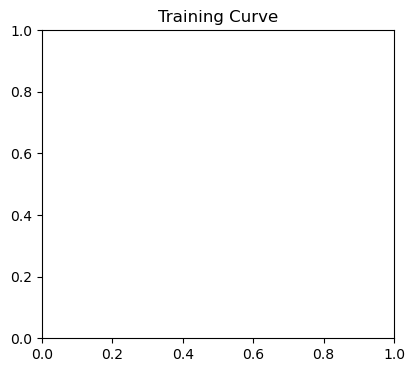

In [31]:
plot_results(epochs, losses, train_acc, val_acc)